Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9307
           1       1.00      1.00      1.00     35688

    accuracy                           1.00     44995
   macro avg       1.00      1.00      1.00     44995
weighted avg       1.00      1.00      1.00     44995

ROC AUC Score: 1.0


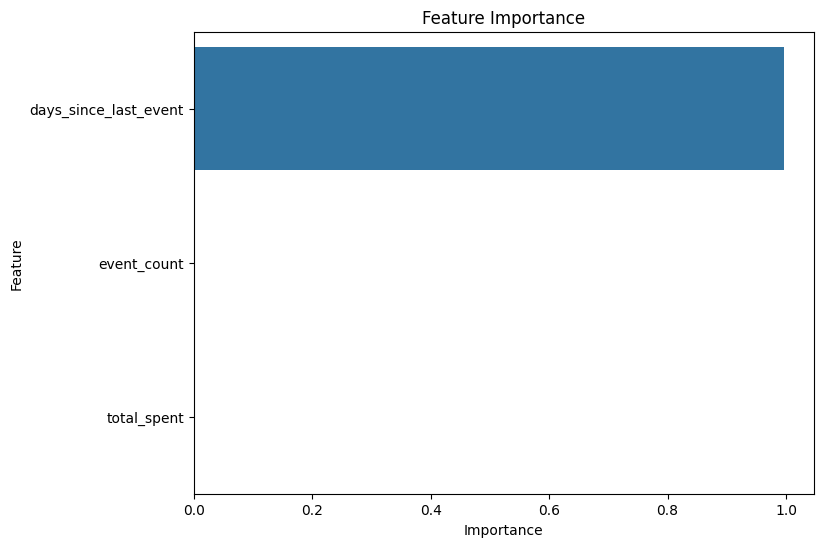

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_csv('events.csv')

# Parse event_time as datetime
data['event_time'] = pd.to_datetime(data['event_time'])

# Basic preprocessing
data = data.drop_duplicates()
data = data.dropna()

# Feature Engineering
# Recency: Days since last activity
recency = data.groupby('user_id')['event_time'].max().reset_index()
recency['days_since_last_event'] = (data['event_time'].max() - recency['event_time']).dt.days

# Frequency: Number of events per user
frequency = data.groupby('user_id')['event_type'].count().reset_index()
frequency.rename(columns={'event_type': 'event_count'}, inplace=True)

# Monetary: Total spent per user
monetary = data[data['event_type'] == 'purchase'].groupby('user_id')['price'].sum().reset_index()
monetary.rename(columns={'price': 'total_spent'}, inplace=True)

# Merging features
features = recency.merge(frequency, on='user_id', how='left').merge(monetary, on='user_id', how='left')
features = features.fillna(0)

# Defining churn: Users with no activity in the last 30 days
churn_threshold = 30
features['is_churned'] = (features['days_since_last_event'] > churn_threshold).astype(int)

# Splitting data into features and target
X = features[['days_since_last_event', 'event_count', 'total_spent']]
y = features['is_churned']

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Model training
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_balanced, y_train_balanced)

# Predictions
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1] if len(clf.classes_) > 1 else None

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
if y_pred_proba is not None:
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
else:
    print("ROC AUC Score: Not defined (only one class in y_test)")

# Feature importance
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': clf.feature_importances_}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance')
plt.show()

# Save processed data and model
features.to_csv('events', index=False)
feature_importances.to_csv('events', index=False)


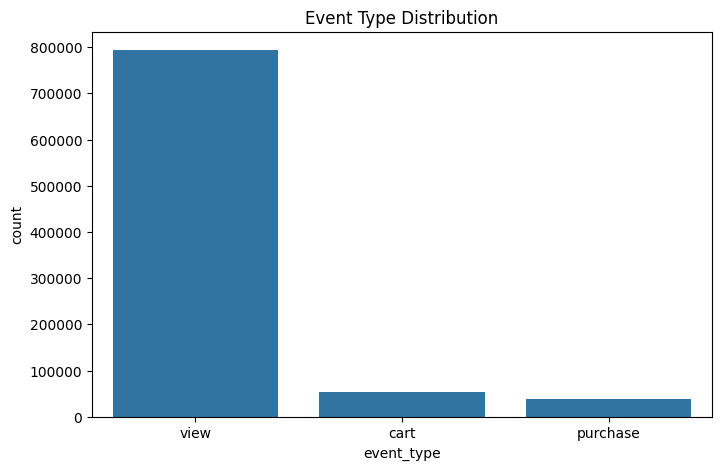

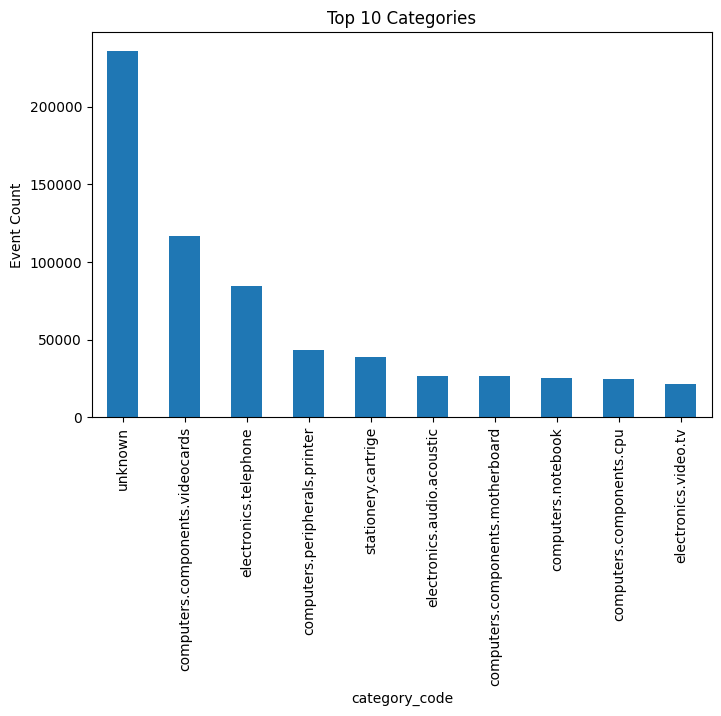

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1913
           1       1.00      1.00      1.00    120227

    accuracy                           1.00    122140
   macro avg       1.00      1.00      1.00    122140
weighted avg       1.00      1.00      1.00    122140

ROC AUC Score: 1.0


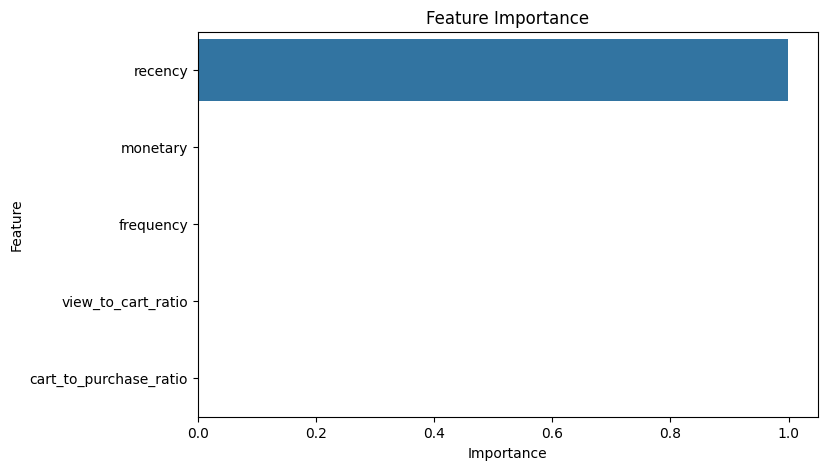

Top Insights and Recommendations:
- Focus on users with high view-to-cart but low cart-to-purchase ratios.
- Target users with low frequency and monetary value using personalized offers.
- Monitor categories/products driving high churn and revamp marketing strategies.


In [9]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Load dataset
file_path = 'events.csv'
events_data = pd.read_csv(file_path)

# Preprocessing
# Convert 'event_time' to datetime
events_data['event_time'] = pd.to_datetime(events_data['event_time'], errors='coerce')

# Drop rows with missing user_session
events_data = events_data.dropna(subset=['user_session'])

# Fill missing values in 'category_code' and 'brand'
events_data['category_code'] = events_data['category_code'].fillna('unknown')
events_data['brand'] = events_data['brand'].fillna('unknown')

# Ensure correct data types
events_data['product_id'] = events_data['product_id'].astype(str)
events_data['category_id'] = events_data['category_id'].astype(str)
events_data['user_id'] = events_data['user_id'].astype(str)

# Exploratory Data Analysis (EDA)
# Event type distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=events_data, x='event_type', order=events_data['event_type'].value_counts().index)
plt.title('Event Type Distribution')
plt.show()

# Top categories
top_categories = events_data['category_code'].value_counts().head(10)
plt.figure(figsize=(8, 5))
top_categories.plot(kind='bar')
plt.title('Top 10 Categories')
plt.ylabel('Event Count')
plt.show()

# User-level analysis
user_behavior = events_data.groupby('user_id').agg(
    total_events=('event_type', 'count'),
    total_views=('event_type', lambda x: (x == 'view').sum()),
    total_cart=('event_type', lambda x: (x == 'cart').sum()),
    total_purchase=('event_type', lambda x: (x == 'purchase').sum())
).reset_index()

# Feature Engineering
# RFM metrics
user_behavior['recency'] = (
    events_data['event_time'].max() - 
    events_data.groupby('user_id')['event_time'].transform('max')
).dt.days
user_behavior['frequency'] = user_behavior['total_events']
user_behavior['monetary'] = events_data[events_data['event_type'] == 'purchase'].groupby('user_id')['price'].transform('sum')

# Replace NaN monetary values with 0
user_behavior['monetary'] = user_behavior['monetary'].fillna(0)

# Behavioral patterns
user_behavior['view_to_cart_ratio'] = user_behavior['total_cart'] / (user_behavior['total_views'] + 1)
user_behavior['cart_to_purchase_ratio'] = user_behavior['total_purchase'] / (user_behavior['total_cart'] + 1)

# Define Churn (no activity in the last 30 days)
user_behavior['churn'] = (user_behavior['recency'] > 30).astype(int)

# Drop rows with missing or infinite values in features
user_behavior = user_behavior.replace([np.inf, -np.inf], np.nan).dropna()

# Modeling
# Prepare features and target variable
features = ['recency', 'frequency', 'monetary', 'view_to_cart_ratio', 'cart_to_purchase_ratio']
X = user_behavior[features]
y = user_behavior['churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)
if hasattr(clf, "predict_proba"):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
else:
    y_pred_proba = np.zeros_like(y_pred)  # Set to zero if predict_proba is unavailable

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
if len(np.unique(y_test)) > 1:  # Avoid error in ROC AUC if only one class is in test set
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
else:
    print("ROC AUC Score cannot be calculated: Only one class present in y_test.")

# Feature Importance
feature_importances = pd.DataFrame({'Feature': features, 'Importance': clf.feature_importances_}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 5))
sns.barplot(data=feature_importances, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.show()

# Recommendations
print("Top Insights and Recommendations:")
print("- Focus on users with high view-to-cart but low cart-to-purchase ratios.")
print("- Target users with low frequency and monetary value using personalized offers.")
print("- Monitor categories/products driving high churn and revamp marketing strategies.")
